### Importing Libraries and dataset Images

In [ ]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import pathlib
import datetime
import time

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir='/content/drive/MyDrive/NTU/CE4042/classified_images'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/NTU/CE4042/classified_images')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

12676

### Prepare Train and Validation data set

In [ ]:
#split data into train and validation dataset
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12676 files belonging to 2 classes.
Using 10141 files for training.
Found 12676 files belonging to 2 classes.
Using 2535 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['female_face', 'male_face']


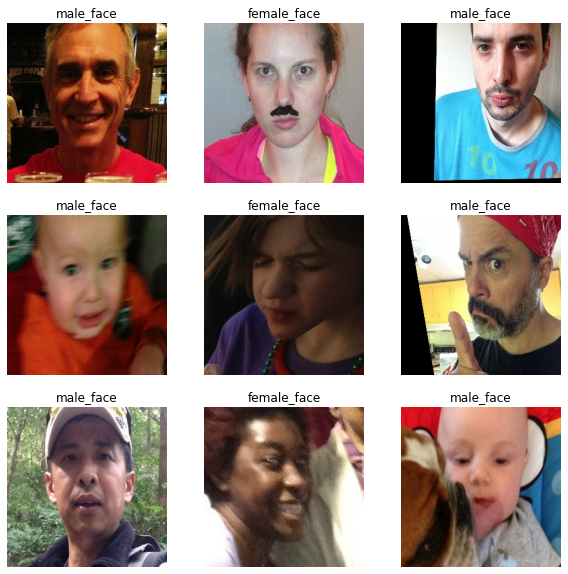

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#normalizing the data to achieve standardization
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Data Augmentation
#### Apply the preprocessing layers to your dataset

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1)  
])

In [ ]:
batch_size = 32

def prepare(ds, augment=False):
  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)

### Inception v3

In [ ]:
#retieving the inception_v3 model from tensorflowhub
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor_model = inception_v3

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(256, 256, 3),
    trainable=True)

#other models that we experimented with
#inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
#feature_extractor_model = inception_v3

#inception_resnet_v2 = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5"
#feature_extractor_model = inception_resnet_v2

#efficientnet_b7 = "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1"
#feature_extractor_model = efficientnet_b7

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 22,065,314
Trainable params: 22,030,882
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)


#Defining early stopping
def early_stop_callback(name):
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

#Callback to restore best model weights 
checkpoint_filepath = './best_weights_file'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
NUM_EPOCHS = 50
#Fitting the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=32,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stop_callback("name"), model_checkpoint_callback])

Epoch 1/50
317/317 [==============================] - ETA: 0s - loss: 0.8382 - acc: 0.7118INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 111s 302ms/step - loss: 0.8382 - acc: 0.7118 - val_loss: 13.4039 - val_acc: 0.5116
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 0.6344 - acc: 0.8206INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 83s 261ms/step - loss: 0.6344 - acc: 0.8206 - val_loss: 1.0699 - val_acc: 0.6698
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 0.5351 - acc: 0.8723INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 83s 261ms/step - loss: 0.5351 - acc: 0.8723 - val_loss: 0.5380 - val_acc: 0.9014
Epoch 4/50
317/317 [==============================] - ETA: 0s - loss: 0.4926 - acc: 0.8831INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 83s 261ms/step - loss: 0.4926 - acc: 0.8831 - val_loss: 0.4635 - val_acc: 0.8895
Epoch 5/50
317/317 [==============================] - 68s 214ms/step - loss: 0.4508 - acc: 0.9019 - val_loss: 0.5225 - val_acc: 0.8647
Epoch 6/50
317/317 [==============================] - 68s 214ms/step - loss: 0.4287 - acc: 0.9063 - val_loss: 0.5361 - val_acc: 0.8895
Epoch 7/50
317/317 [==============================] - ETA: 0s - loss: 0.4072 - acc: 0.9107INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 83s 261ms/step - loss: 0.4072 - acc: 0.9107 - val_loss: 0.4271 - val_acc: 0.9049
Epoch 8/50
317/317 [==============================] - 68s 214ms/step - loss: 0.3881 - acc: 0.9230 - val_loss: 0.5470 - val_acc: 0.8446
Epoch 9/50
317/317 [==============================] - 68s 214ms/step - loss: 0.3880 - acc: 0.9190 - val_loss: 0.6235 - val_acc: 0.8162
Epoch 10/50
317/317 [==============================] - 68s 214ms/step - loss: 0.3615 - acc: 0.9247 - val_loss: 0.4606 - val_acc: 0.8888
Epoch 11/50
317/317 [==============================] - ETA: 0s - loss: 0.3512 - acc: 0.9301INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 83s 262ms/step - loss: 0.3512 - acc: 0.9301 - val_loss: 0.3839 - val_acc: 0.9128
Epoch 12/50
317/317 [==============================] - ETA: 0s - loss: 0.3392 - acc: 0.9310INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 83s 262ms/step - loss: 0.3392 - acc: 0.9310 - val_loss: 0.3596 - val_acc: 0.9290
Epoch 13/50
317/317 [==============================] - 68s 214ms/step - loss: 0.3349 - acc: 0.9347 - val_loss: 0.3634 - val_acc: 0.9258
Epoch 14/50
317/317 [==============================] - 68s 214ms/step - loss: 0.3291 - acc: 0.9363 - val_loss: 0.4371 - val_acc: 0.9085
Epoch 15/50
317/317 [==============================] - 68s 214ms/step - loss: 0.3150 - acc: 0.9397 - val_loss: 0.4350 - val_acc: 0.8793
Epoch 16/50
317/317 [==============================] - 68s 214ms/step - loss: 0.3143 - acc: 0.9460 - val_loss: 1.5357 - val_acc: 0.8706
Epoch 17/50
317/317 [==============================] - 68s 214ms/step - loss: 0.3032 - acc: 0.9484 - val_loss: 0.4720 - val_acc: 0.9006
Epoch 18/50
317/317 [==============================] - 68s 214ms/step - loss: 0.2996 - acc: 0.9480 - val_loss: 0.5389 - val_acc: 0.8584
Epoch 19/50
317/317 [==============================] - 68s 2

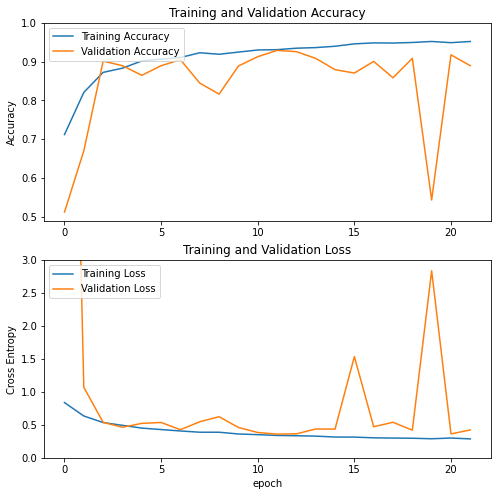

In [ ]:
#plotting the accuracy and the loss 
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Model Predictions

In [ ]:
#predicting the gender of the images
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_id
predicted_label_batch=[]
for i in predicted_id.numpy():
    if(i==1):
        predicted_label_batch.append("male")
    else:
        predicted_label_batch.append("female")
print(predicted_label_batch)

['female', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'female', 'female', 'male', 'male', 'female', 'female', 'female', 'female', 'female', 'male', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'female', 'female', 'female']


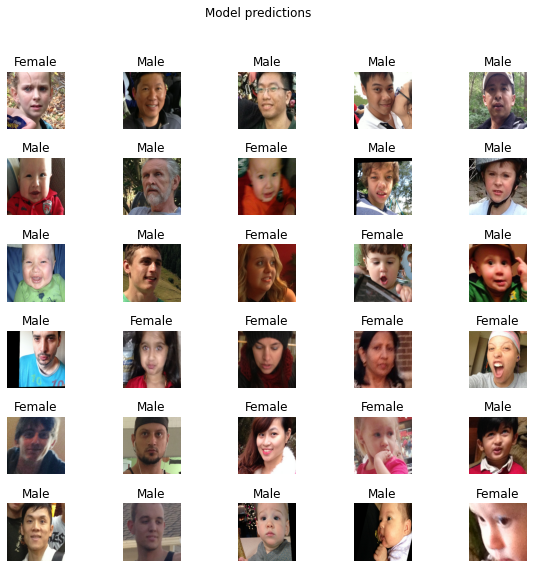

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
t = time.time()
#saving the model to be used later
export_path = "/content/drive/MyDrive/Colab Notebooks/{}".format(int(t))
model.save(export_path)

export_path
#/content/drive/MyDrive/Colab Notebooks/1636800444

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/1636800444/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/1636800444/assets


'/content/drive/MyDrive/Colab Notebooks/1636800444'